In [3]:
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Оценка качества аннотаторов

Я хочу посчитать IAA (Inter-annotator agreement)

Если у данных нет reviewer-а, буду считать общее качество разметки аннотаторов относительно друг друга

Для этого подходит, например, [Fleiss Kappa](https://en.wikipedia.org/wiki/Fleiss%27_kappa#Worked_example)

In [3]:
data = pd.DataFrame({})

# Просто стакаю все train-ы в один dataframe
for path in sorted(glob('data/VKT-930-???.json')):
    data = pd.concat((data, pd.read_json(path)))
    
data.head(5)

,text,extra_info,results,task_type,dataset_id,Null,task_id
0,Предпосылка: Девушка с зонтов шумит возле вход...,{'id': 0},"[{'user_id': 62296154, 'value': {'value': '169...",text,512.0,NaN,NaN
1,Предпосылка: Маленький мальчик катается на вел...,{'id': 1},"[{'user_id': 313883831, 'value': {'value': '16...",text,512.0,NaN,NaN
2,Предпосылка: Наука основана на эмпирических да...,{'id': 3},"[{'user_id': 142862059, 'value': {'value': '16...",text,512.0,NaN,18876.0
3,Предпосылка: Молодой человек в спортивной форм...,{'id': 4},"[{'user_id': 132477092, 'value': {'value': '16...",text,512.0,NaN,18876.0
4,Предпосылка: Мужчина сидит на диване смотря на...,{'id': 5},"[{'user_id': 132954861, 'value': {'value': '16...",text,512.0,NaN,18876.0


In [4]:
def annotations_count(sample, f=None, user_id=None, exclude_user_id=None):
    # Считаю число различных аннотаций для семпла
    counts = [0, 0, 0]
    for a in sample:
        # Юзеры, которых я хочу дропнуть
        if exclude_user_id is not None and a['user_id'] in exclude_user_id:
            continue
        if user_id is None or a['user_id'] == user_id:
            if a['value']['text'] == 'Логическое следование':
                counts[0] += 1
            elif a['value']['text'] == 'Нейтральная взаимосвязь':
                counts[1] += 1
            elif a['value']['text'] == 'Противоречие':
                counts[2] += 1
            # Если хоть одна метка "Плохой пример", то дропаю этой семпл
            elif a['value']['text'] == 'Плохой пример':
                return None
            
    # Применяю функцию
    if f is not None:
        return f(counts)
    
    return counts
        
    
ann_per_samle = data['results'].apply(lambda x: annotations_count(x, f=np.sum))
ann_per_samle = ann_per_samle.dropna()
values, counts = np.unique(ann_per_samle, return_counts=True)
print(values, counts)

# ~99% 3 аннотации на семпл

[3. 4. 5. 6. 7.] [66033    80     5     1     1]


In [5]:
# Посмотрим на распределение классов
ann_argmax = data['results'].apply(lambda x: annotations_count(x, f=np.argmax))
ann_argmax = ann_argmax.dropna()
values, counts = np.unique(ann_argmax, return_counts=True)
print(values, counts)
# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

[0. 1. 2.] [18906 28277 18937]


In [6]:
# Для получения списка аннотаторов
def get_annotators(sample):
    ann = []
    for a in sample:
        ann.append(a['user_id'])
        
    return ann

# Проверяю, есть ли выраженный максимум
def ambiguity(counts):
    return not np.max(counts) > np.sum(counts) // 2

Для оценки каждого аннотатора буду смотреть, какая доля его ответов совпадает с мнением большинства (при условии существования большинства).

Допустим, все аннотаторы отвечают случайно и для каждого семпла 3 ответа. Тогда при пропуске семплов, аннотации которых не содержат максимума - [1, 1, 1], значение разметки для конкретного аннотатора будет совпадать с максимумом в ~72% случаев (Учитывая распределение классов, а при равномерном распределении $\frac{5}{7} = 0.714$).  Тогда мы точно можем удалить из датасета разметку аннотаторов, не проходящих этот трешхолд.

In [7]:
# На всякий случай проверил
def random_check():
    p = [21431.0, 32722, 21500]
    p /= np.sum(p)
    arr = np.random.choice(np.arange(3), size=3, p=p)
    counts = [0, 0, 0]
    for item in arr:
        counts[item] += 1

    x = arr[0]
    if ambiguity(counts):
        return None
    
    return np.argmax(counts) == x

a = []
for k in range(100000):
    res = random_check()
    if res is not None:
        a.append(res)
        
values, counts = np.unique(a, return_counts=True)
print(values, counts)
print(counts[1] / np.sum(counts))

[False  True] [22069 57155]
0.7214354236090074


### Label Matching

In [8]:
# Проверяю для семпла и аннотатора, согласен ли он с мнением большинства
def user_inconsistency(sample, user_id):
    counts = annotations_count(sample)
    user_counts = annotations_count(sample, user_id=user_id)
    
    if counts is None or user_counts is None:
        return None
    
    if np.sum(user_counts) == 0 or ambiguity(counts):
        return None
    
    return np.argmax(counts) != np.argmax(user_counts)


# Получаю аннотаторов
annotators = list(data['results'].apply(lambda x: get_annotators(x)))
annotators = np.unique(np.concatenate(annotators))

# Для каждого считаю долю семплов, в которых он согласен с большинством
scores = []

for ann in annotators:
    annotation_counts = data['results'].apply(lambda x: user_inconsistency(x, user_id=ann))
    annotation_counts = annotation_counts.dropna()
    values, counts = np.unique(annotation_counts, return_counts=True)
    counts = np.round(counts / len(annotation_counts), 2)
    
    scores.append((ann, counts[0]))
    
scores = sorted(scores, key=lambda x: x[1])

# Оставляю только id в порядке возрастания согласованности
annonator_ids = []
for k in range(len(scores)):
    annonator_ids.append(scores[k][0])

In [9]:
# Первых 4 точно можно удалять из датасета
print(scores[:10])
np.mean([item[1] for item in scores])

[(322467706, 0.52), (209935302, 0.6), (592811653, 0.65), (374774459, 0.7), (179483767, 0.72), (749097, 0.75), (422248376, 0.76), (611288574, 0.77), (212577011, 0.78), (121963394, 0.79)]


0.8723809523809524

In [10]:
# Например
print(data.iloc[69]['text'])
data.iloc[69]['results']

Предпосылка: Мальчик плавает в бассейне пока его мама смотрит на него с балкона. Гипотеза: Мальчик играет в футбол на улице вдали от дома.


[{'user_id': 322467706,
  'value': {'value': '1696', 'text': 'Логическое следование'},
  'time': 1683289355},
 {'user_id': 541368305,
  'value': {'value': '1698', 'text': 'Противоречие'},
  'time': 1683357848},
 {'user_id': 137842958,
  'value': {'value': '1698', 'text': 'Противоречие'},
  'time': 1683418060}]

In [110]:
# Если 2 аннотации на семпл и есть выраженный максимум, дополню для 3
# Если >3, то дропаю
# Необходимо для расcчета fleiss_kappa
def make_triplet(counts):
    if np.sum(counts) == 2 and np.max(counts) == 2:
        counts[np.argmax(counts)] = 3
        return counts
    if np.sum(counts) == 3:
        return counts

    return None


# Буду удалять по аннотатору из данных для k худших аннотаторов
# Для полученных значений считаю метрику fleiss_kappa 
low_k = 60 # всего 105
fk_scores = []
data_sizes = []
data_len = None

for k in range(low_k):
    ann_rates = data['results'].apply(lambda x: annotations_count(x, f=make_triplet,
                                exclude_user_id=annonator_ids[:k]))
    ann_rates = ann_rates.dropna()
    fk = fleiss_kappa(np.array(list(ann_rates)))
    fk_scores.append(fk)
    if data_len is None:
        data_len = len(ann_rates)
    # Считаю на сколько процентов уменьшается датасет от начального
    data_sizes.append((1 - len(ann_rates) / data_len) * -100)

А надо ли считать по классам?

Fleiss' Kappa – это статистическая мера, используемая для оценки надежности согласия между оценщиками при классификации N элементов в C категорий. В отличие от Коэффициента Каппа Коэна, который рассчитывается для двух оценщиков, Fleiss' Kappa работает для любого числа оценщиков и является усредненной мерой согласия для всех категорий.

Fleiss' Kappa обычно рассчитывается для всего набора данных и дает одно значение, которое показывает уровень согласия между оценщиками в целом, а не для каждого класса по отдельности. Однако, если вы хотите оценить согласие по каждому классу индивидуально, вы можете адаптировать расчет, используя идею, аналогичную Fleiss' Kappa, но применяя его отдельно к каждому классу.

Вот как можно было бы подойти к этому:

1. Для каждого класса создайте отдельную таблицу сопряженности, где строки представляют элементы, а столбцы – оценщиков.

2. В каждой ячейке таблицы укажите, назначил ли оценщик соответствующий элемент данному классу (1) или нет (0).

3. Рассчитайте пропорцию согласия внутри каждого класса:
   - $P_i $ – пропорция согласия по i-му элементу.
   - $P_{mean}$ – средняя пропорция согласия по всем элементам в классе.

4. Рассчитайте ожидаемую пропорцию согласия случайно $ P_e $ для класса, используя маргинальные тоталы.

5. Примените формулу Fleiss' Kappa для каждого класса:
   $K = \frac{P_{mean} - P_e}{1 - P_e}$

Это даст вам значение Kappa для каждого класса, отражающее степень согласия между оценщиками исключительно для этого класса.

Обратите внимание, что при таком подходе значения Kappa для отдельных классов могут не вполне отражать общее согласие, так как они не учитывают распределение оценок по другим классам. Для оценки общего согласия между оценщиками все же рекомендуется использовать общий Fleiss' Kappa для всего набора данных.

Text(0, 0.5, '% data loss')

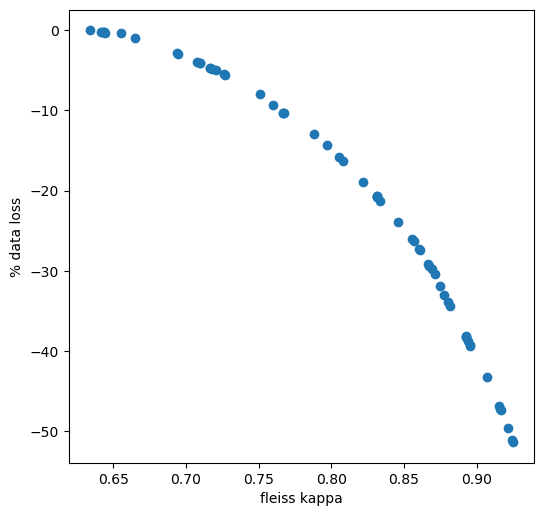

In [213]:
plt.figure(figsize=(6, 6), dpi=100)

plt.scatter(fk_scores, data_sizes)
plt.xlabel('fleiss kappa')
plt.ylabel('% data loss')

Получаем фронт паретто. Можем выбрать оптимальное соотношение между IAA и потерей данных. 

## Pairvise KL-divergence

In [20]:
# Сортированные по label matching скору аннотаторы (по возрастанию)
annotators = [item[0] for item in scores]

threshold = 30
threshold_arr = np.zeros_like(annotators, dtype=bool)

for i, ann in enumerate(annotators):
    annotation_counts = data['results'].apply(lambda x: annotations_count(x, user_id=ann))
    annotation_counts = annotation_counts.dropna()
    counts = np.sum(list(annotation_counts))
    
    if counts >= threshold:
        threshold_arr[i] = True

In [24]:
annotators_thresh = np.array(annotators)[threshold_arr]
distributions = np.zeros((len(annotators_thresh), 3))

for i, ann in enumerate(annotators_thresh):
    annotation_counts = data['results'].apply(lambda x: annotations_count(x, user_id=ann))
    annotation_counts = annotation_counts.dropna()
    distributions[i] = np.sum(list(annotation_counts), axis=0)

In [54]:
# Нормирую
for i in range(len(distributions)):
    distributions[i] /= np.sum(distributions[i])

In [73]:
# Функция для расчета KL-дивергенции
def kl_divergence(p, q):
#     p = np.asarray(p, dtype=np.float32) + 1e-10
#     q = np.asarray(q, dtype=np.float32) + 1e-10
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Инициализировать матрицу KL-дивергенций
num_assessors = len(annotators_thresh)
kl_matrix = np.zeros((num_assessors, num_assessors))

# Вычислить KL-дивергенцию попарно между распределениями
for i in range(num_assessors):
    for j in range(num_assessors):
        if i != j:
#             kl_matrix[i, j] = kl_divergence(distributions[i], distributions[j])
            kl_matrix[i, j] = kl_divergence(distributions[i] / np.sum(distributions[i]), \
                                            distributions[j] / np.sum(distributions[j]))

# Визуализировать матрицу KL-дивергенций
# sns.heatmap(kl_matrix, annot=True, fmt=".2f")
# plt.title('KL Divergence Matrix')
# plt.xlabel('Assessor')
# plt.ylabel('Assessor')
# plt.show()

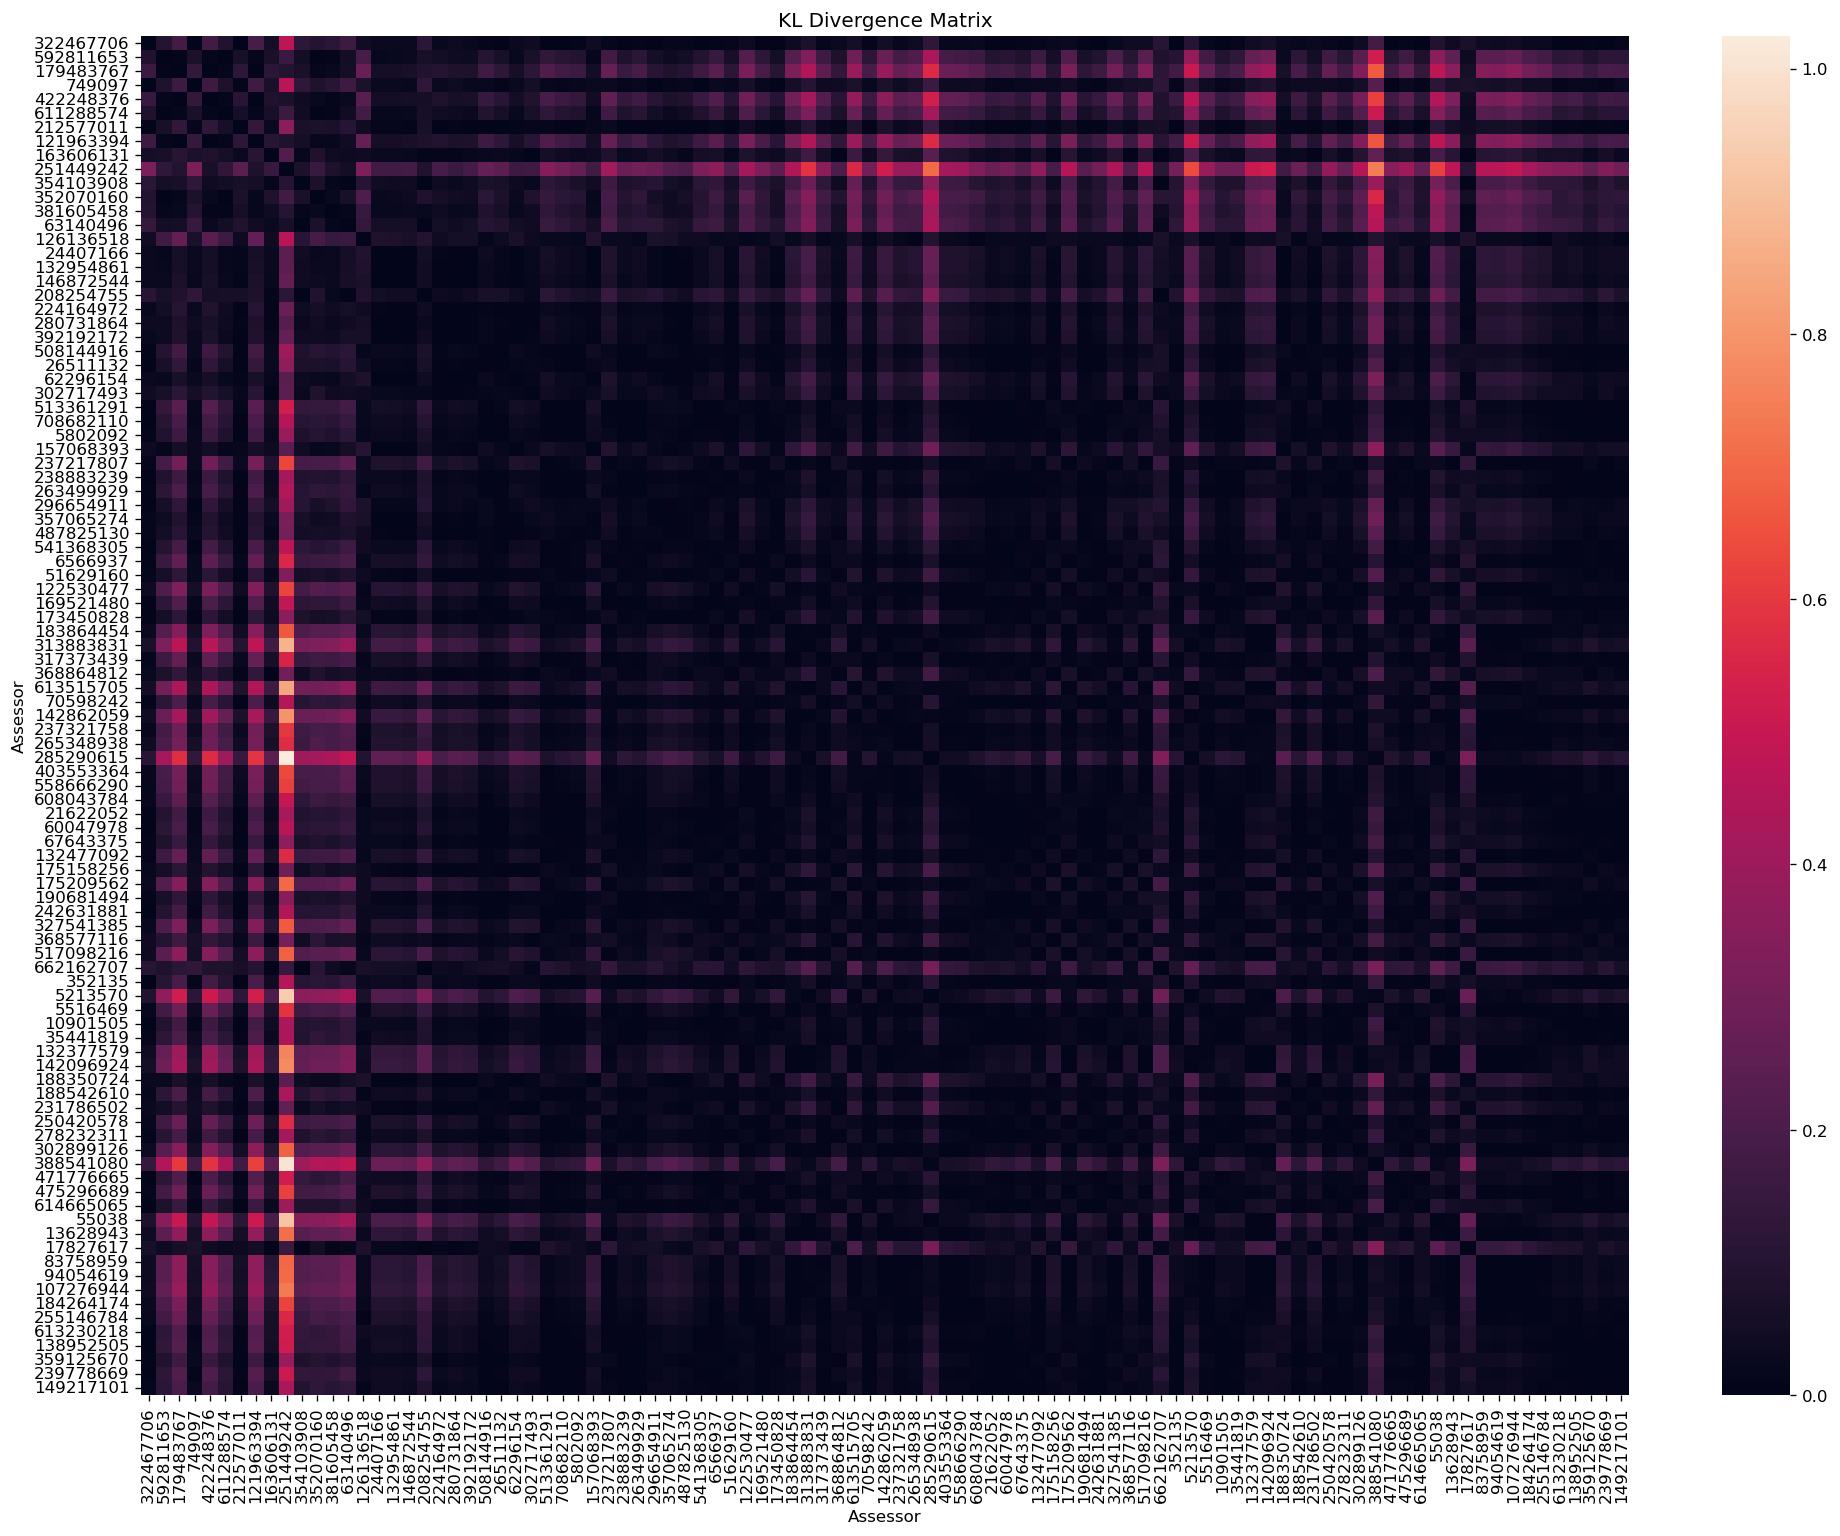

In [74]:
k = -1

plt.figure(figsize=(20, 15), dpi=120)
sns.heatmap(kl_matrix[:k, :k], annot=False, fmt=".2f", \
            xticklabels=annotators_thresh[:k], yticklabels=annotators_thresh[:k])
plt.title('KL Divergence Matrix')
plt.xlabel('Assessor')
plt.ylabel('Assessor')
plt.show()

## EDA

In [4]:
data = pd.DataFrame({})

# Просто стакаю все train-ы в один dataframe
for path in sorted(glob('data/VKT-930-???.json')):
    data = pd.concat((data, pd.read_json(path)))
    
data.head(5)

data = data.reset_index(drop=True)
data

,text,extra_info,results,task_type,dataset_id,Null,task_id
0,Предпосылка: Девушка с зонтов шумит возле вход...,{'id': 0},"[{'user_id': 62296154, 'value': {'value': '169...",text,512.0,NaN,NaN
1,Предпосылка: Маленький мальчик катается на вел...,{'id': 1},"[{'user_id': 313883831, 'value': {'value': '16...",text,512.0,NaN,NaN
2,Предпосылка: Наука основана на эмпирических да...,{'id': 3},"[{'user_id': 142862059, 'value': {'value': '16...",text,512.0,NaN,18876.0
3,Предпосылка: Молодой человек в спортивной форм...,{'id': 4},"[{'user_id': 132477092, 'value': {'value': '16...",text,512.0,NaN,18876.0
4,Предпосылка: Мужчина сидит на диване смотря на...,{'id': 5},"[{'user_id': 132954861, 'value': {'value': '16...",text,512.0,NaN,18876.0
...,...,...,...,...,...,...,...
70026,Предпосылка: Генетически измененные овощи — эт...,{'id': 27},"[{'user_id': 94054619, 'value': {'value': '172...",NaN,NaN,NaN,NaN
70027,Предпосылка: Женщина катается на велосипеде с ...,{'id': 28},"[{'user_id': 184264174, 'value': {'value': '17...",NaN,NaN,NaN,NaN
70028,Предпосылка: Молодой человек находится на пляж...,{'id': 29},"[{'user_id': 94054619, 'value': {'value': '172...",NaN,NaN,NaN,NaN
70029,Предпосылка: Команда друзей готовит пикник в л...,{'id': 30},"[{'user_id': 184264174, 'value': {'value': '17...",NaN,NaN,NaN,NaN


[ 3.  4.  5.  6.  7. -1.] [66033    80     5     1     1  3911]


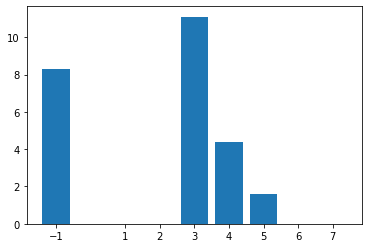

In [33]:
ann_per_samle = data['results'].apply(lambda x: annotations_count(x, np.sum))
values, counts = np.unique(ann_per_samle, return_counts=True)
values[-1] = -1
print(values, counts)
plt.bar(values, np.log(counts))
plt.xticks([-1, 1, 2, 3, 4, 5, 6, 7])
plt.show()
# ~6% плохой пример
# ~99% 3 аннотации на семпл

<BarContainer object of 3 artists>

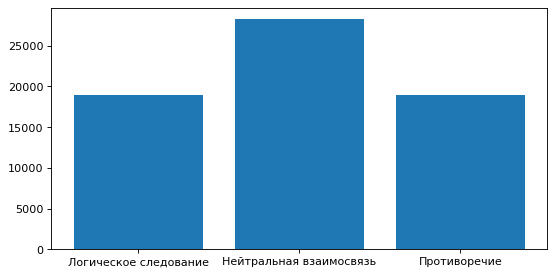

In [56]:
plt.figure(figsize=(8, 4), dpi=80)

# Посмотрим на распределение классов
ann_argmax = data['results'].apply(lambda x: annotations_count(x, f=np.argmax))
ann_argmax = ann_argmax.dropna()
values, ann_argmax = np.unique(ann_argmax, return_counts=True)
values = ['Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие']
plt.bar(values, ann_argmax)

# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

<BarContainer object of 3 artists>

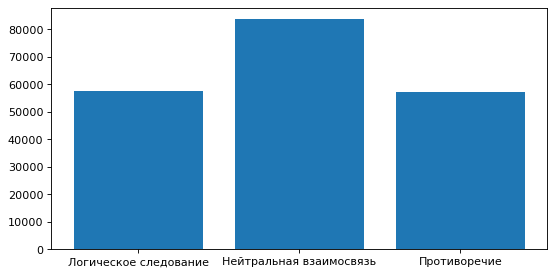

In [91]:
plt.figure(figsize=(8, 4), dpi=80)

# Посмотрим на распределение классов
ann_all = data['results'].apply(lambda x: annotations_count(x))
ann_all = ann_all.dropna()
ann_all = np.sum(list(ann_all), axis=0)

values = ['Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие']
plt.bar(values, ann_all)

# 'Логическое следование', 'Нейтральная взаимосвязь', 'Противоречие'

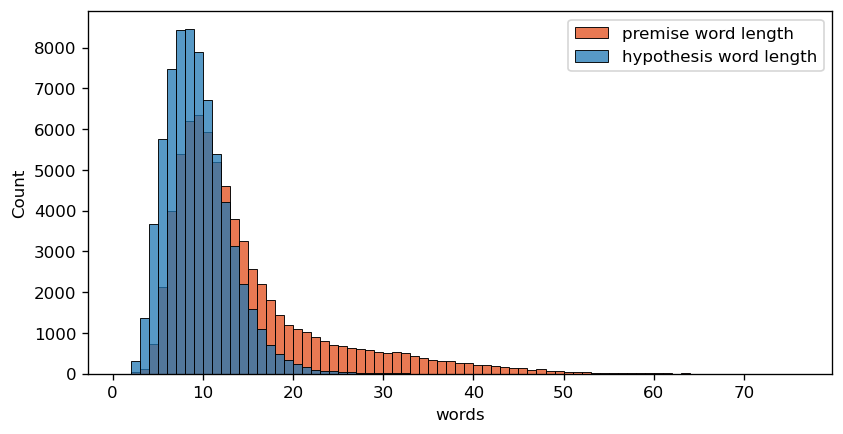

In [8]:
plt.figure(figsize=(8, 4), dpi=120)

def parse_text(text, f=None):
    premise, hypothethis = text.split(" Гипотеза: ")
    premise = premise.lstrip("Предпосылка: ")
    
    if f is not None:
        return f(premise, hypothethis)
    return premise, hypothethis

def premise_char_length(premise, hypothethis):
    return len(premise)

def premise_word_length(premise, hypothethis):
    return len(premise.split(' '))

def hypothethis_char_length(premise, hypothethis):
    return len(hypothethis)

def hypothethis_word_length(premise, hypothethis):
    return len(hypothethis.split(' '))


premise_wl = data['text'].apply(lambda text: parse_text(text, f=premise_word_length))
premise_wl = np.array(list(premise_wl))
sns.histplot(premise_wl, binwidth=1, color='#e24c1a')

hypothethis_wl = data['text'].apply(lambda text: parse_text(text, f=hypothethis_word_length))
hypothethis_wl = np.array(list(hypothethis_wl))
sns.histplot(hypothethis_wl, binwidth=1)

plt.xlabel('words')
plt.legend(labels=['premise word length', 'hypothesis word length'])

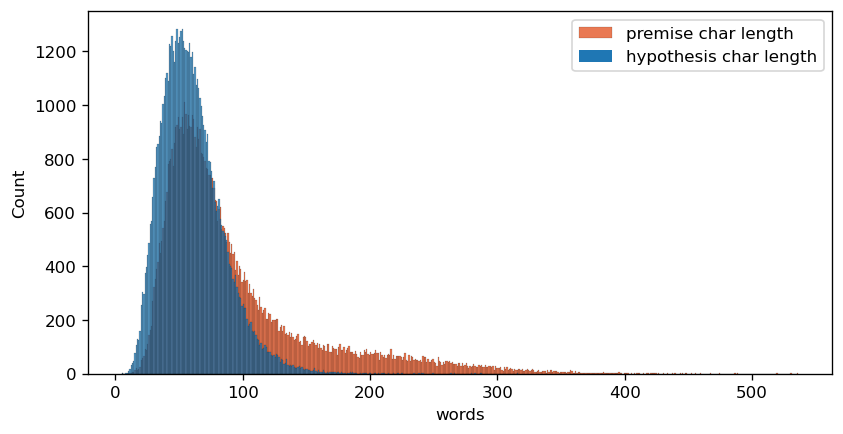

In [140]:
plt.figure(figsize=(8, 4), dpi=120)

premise_cl = data['text'].apply(lambda text: parse_text(text, f=premise_char_length))
premise_cl = np.array(list(premise_cl))
sns.histplot(premise_cl, binwidth=1, color='#e24c1a')

hypothethis_cl = data['text'].apply(lambda text: parse_text(text, f=hypothethis_char_length))
hypothethis_wl = np.array(list(hypothethis_cl))
sns.histplot(hypothethis_cl, binwidth=1)

plt.xlabel('words')
plt.legend(labels=['premise char length', 'hypothesis char length'])

### BoW, WordCloud

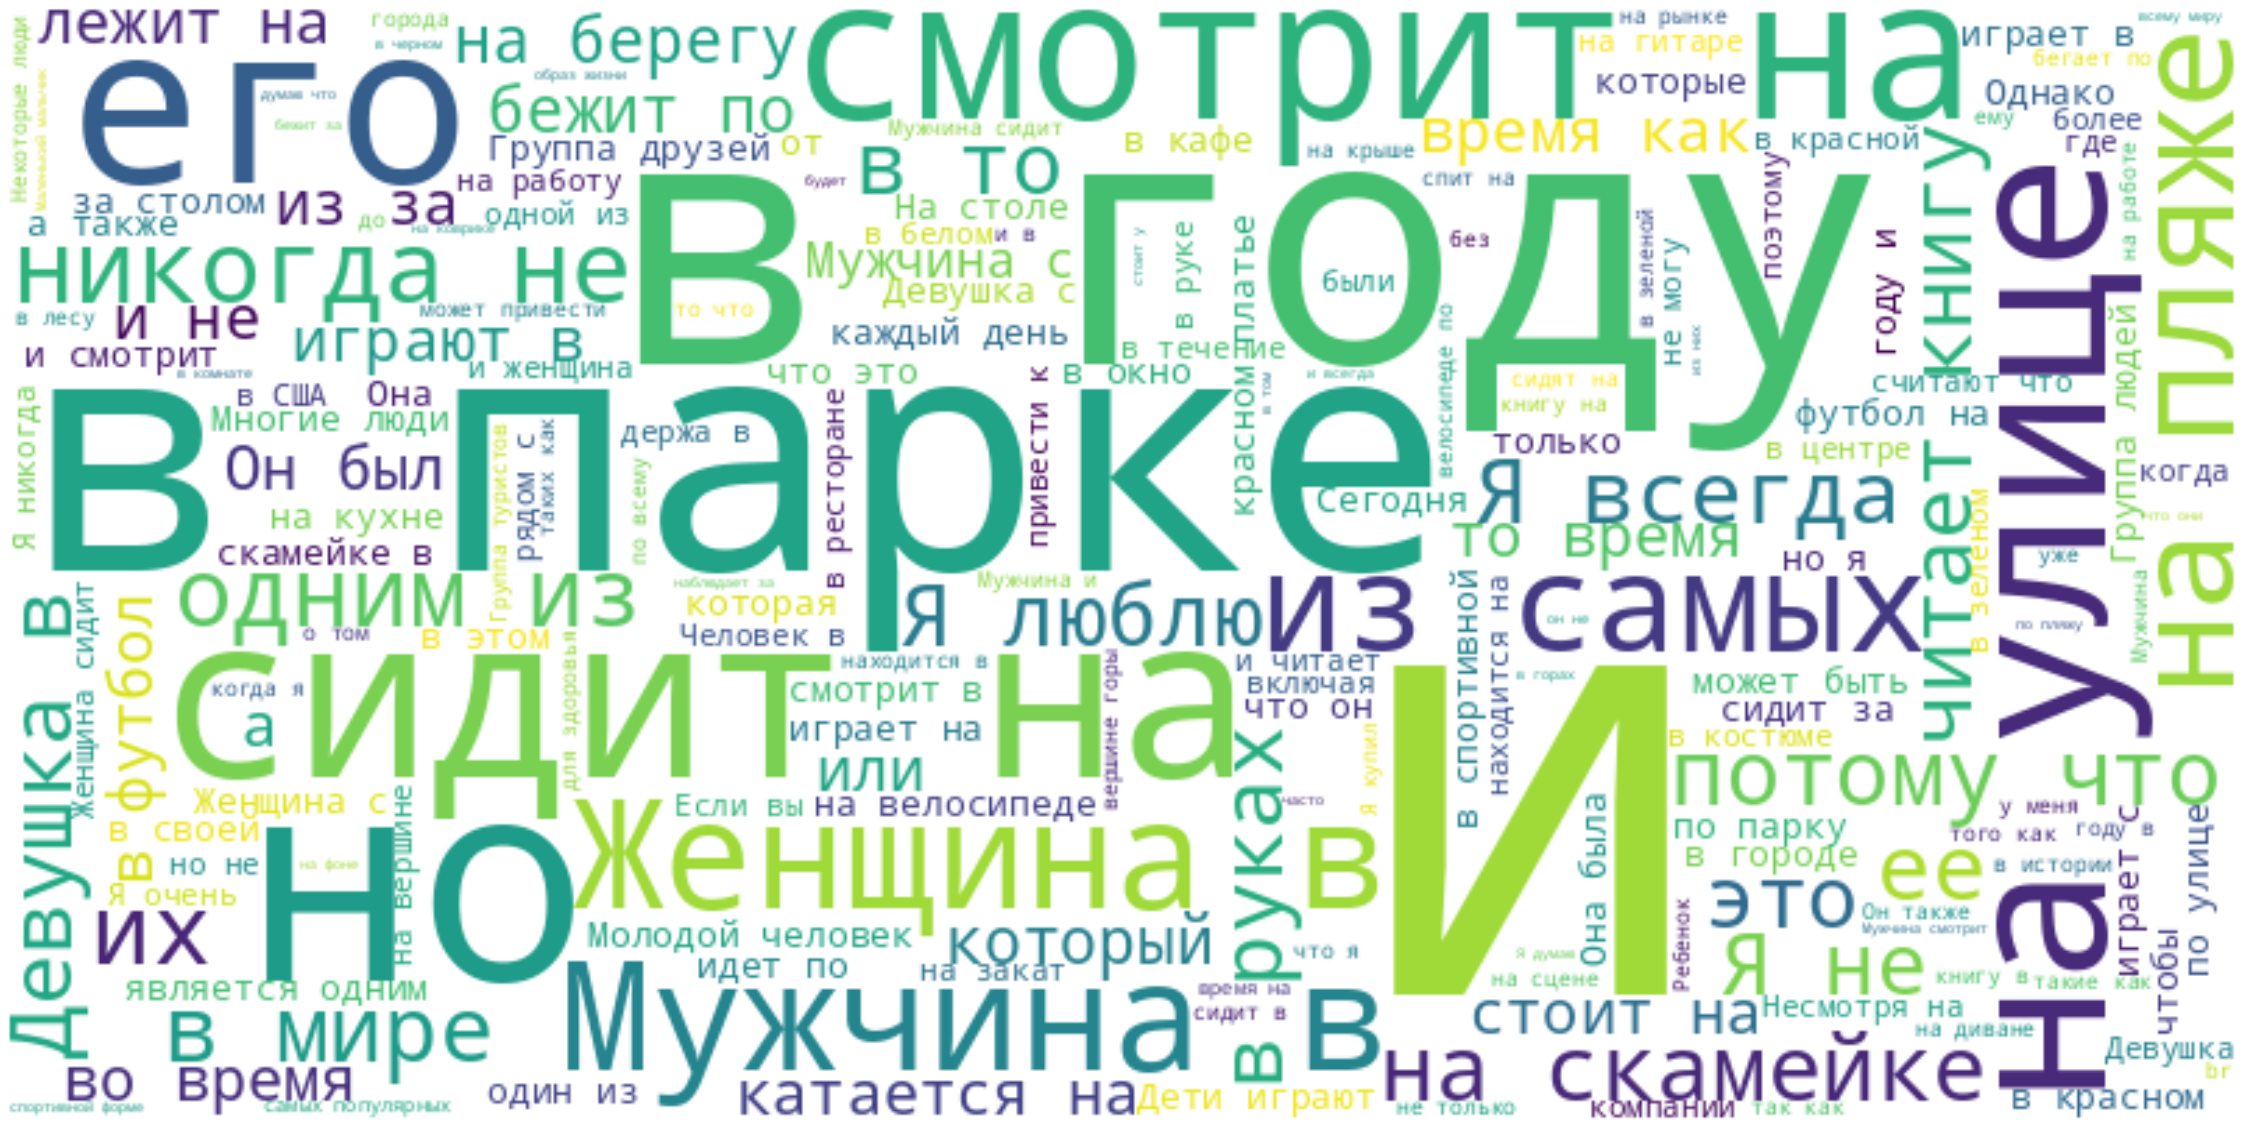

In [11]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Надо добавить лемматизацию?

text = data['text'].apply(lambda x: parse_text(x)[0])

# Создание объекта WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
 
# Отображение сгенерированного изображения:
plt.figure(figsize=(40, 40)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Убрать оси для более чистого вида
plt.show()

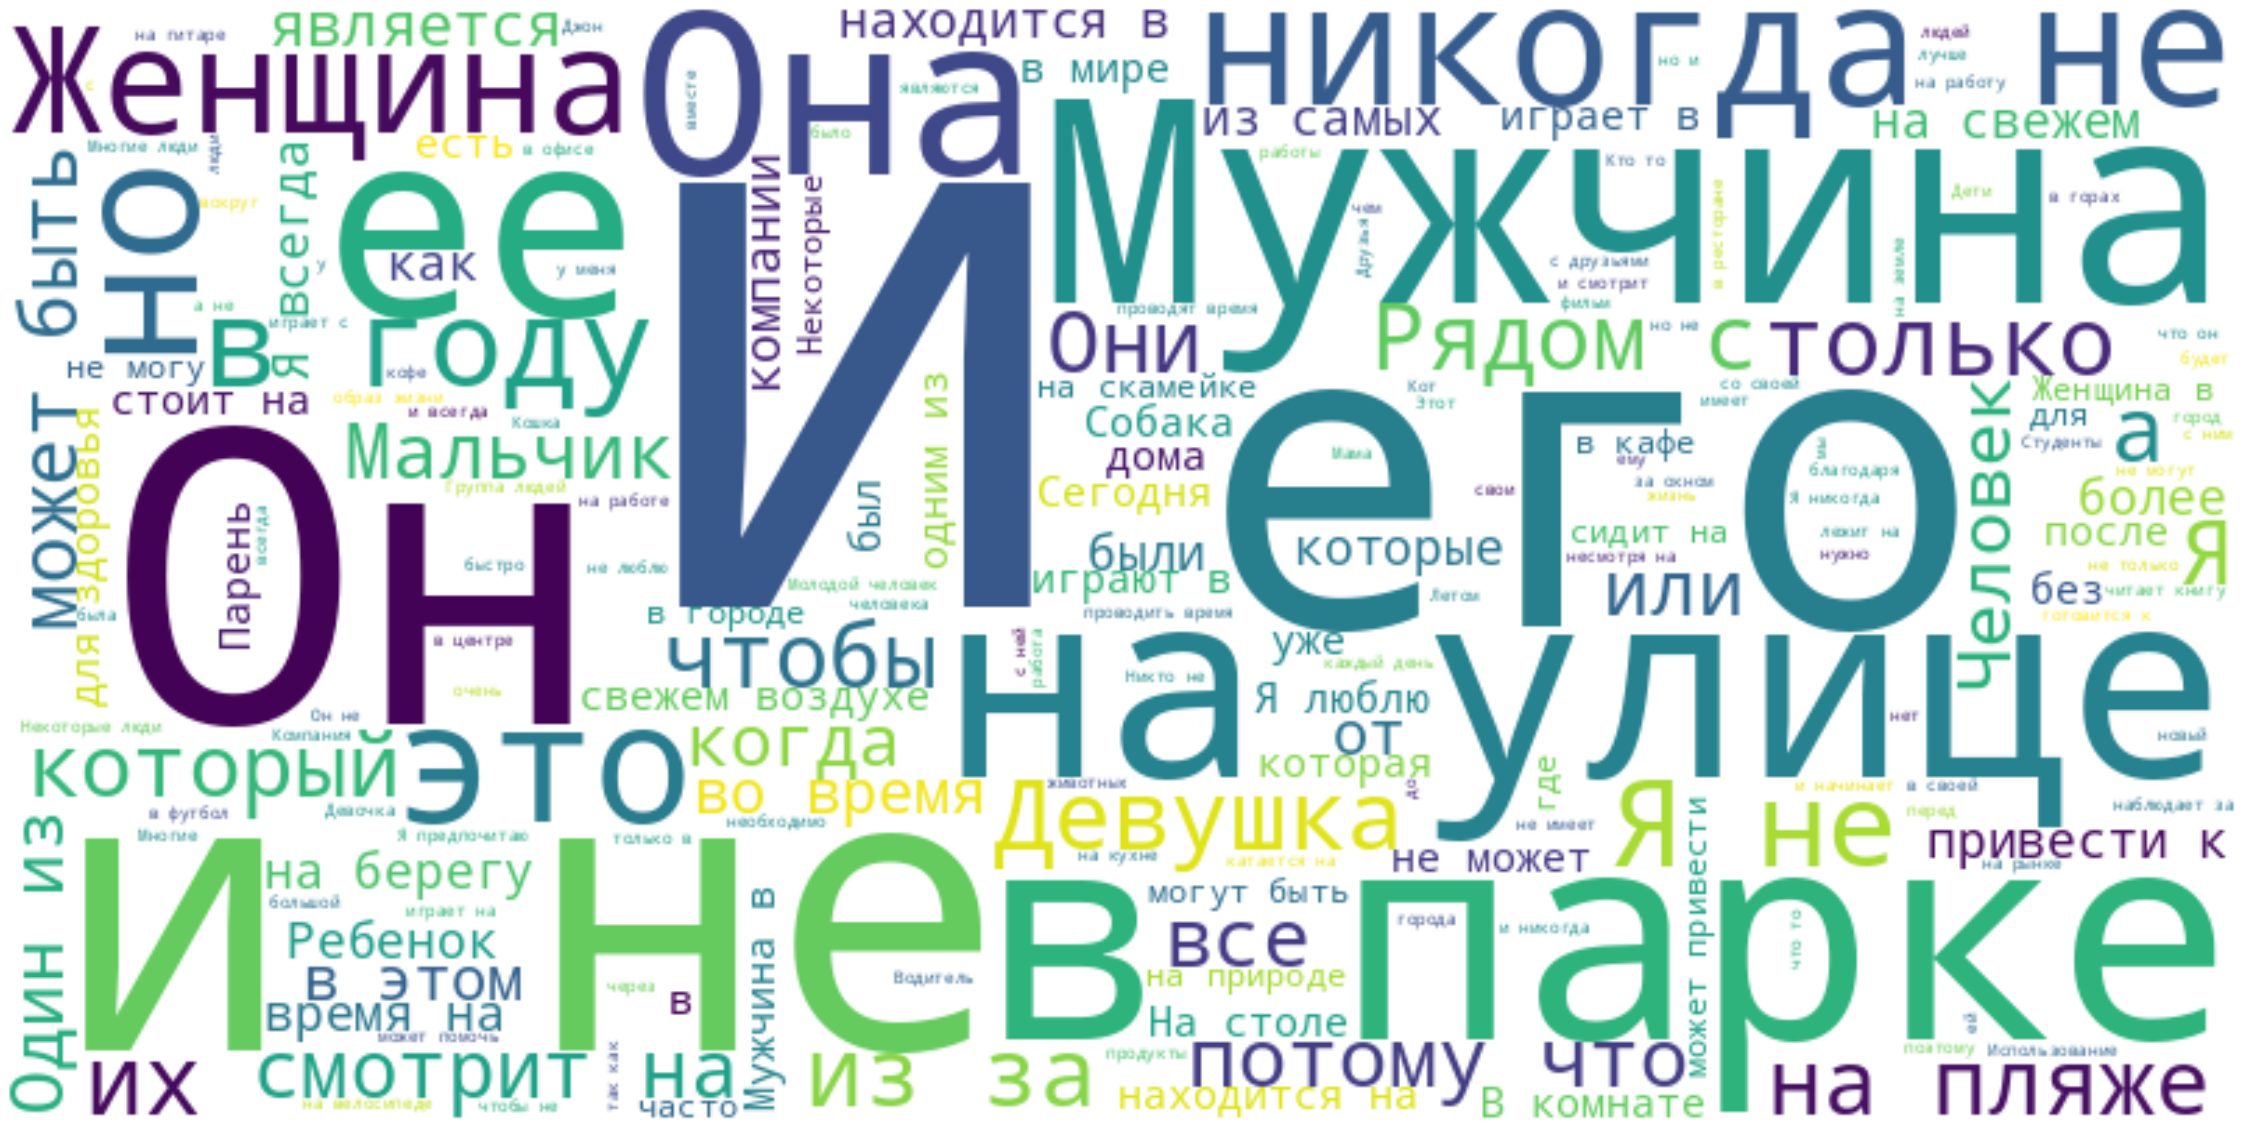

In [12]:
text = data['text'].apply(lambda x: parse_text(x)[1])

# Создание объекта WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
 
# Отображение сгенерированного изображения:
plt.figure(figsize=(40, 40)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Убрать оси для более чистого вида
plt.show()